In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
train_df = pd.read_csv("./sales_train.csv")
test_df = pd.read_csv("./test.csv")

items_df = pd.read_csv("./items.csv")
item_categories__df = pd.read_csv("./item_categories.csv")
shops_df = pd.read_csv("./shops.csv")

In [30]:
train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [31]:
item_categories__df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


# Feature Engineering
- Converting dates fields to usable pandas dates.
- Aggregating monthly sales per item and per shop.

In [32]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['day'] = train_df['date'].dt.day

monthly_sales = train_df.groupby(['shop_id', 'item_id' ,'month', 'year'])['item_cnt_day'].sum().reset_index()
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
# monthly_sales is now a usable dataset

Creating a lag feature allows us to capture temporal patterns and to handle autocorrelation.
The ```shift``` function will shift $lag$ times the starting address of each
lag column, so each month got the last months starting address.

In [33]:
def add_lag_feature(df: pd.DataFrame, n: int):
    for lag in range(1, n + 1):
        df[f'lag_{lag}'] = df.groupby(['shop_id', 'item_id', 'item_cnt_month'])['item_cnt_month'].shift(lag)
    return df

monthly_sales = add_lag_feature(monthly_sales, 3)

Rolling takes the average of fixed-size window that slides over the data, one point at time. So you get a moving view of the average.

In [34]:
monthly_sales['rolling_mean'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3).mean())

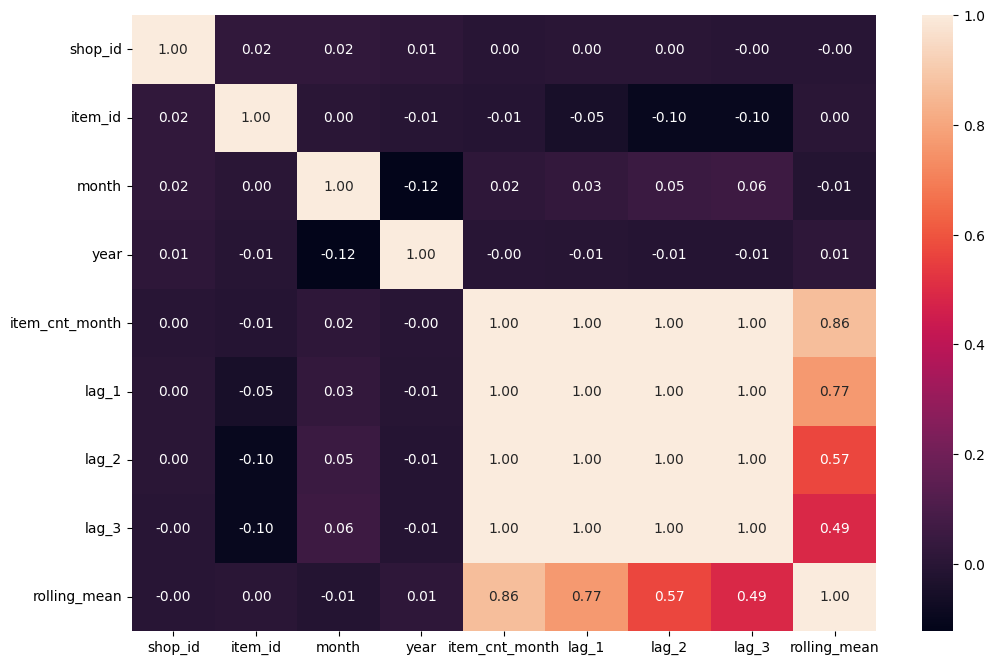

In [35]:
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_sales.corr(), annot=True, fmt='.2f')
plt.show()

### XGBoost 

In [41]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x = monthly_sales.drop(columns=['item_cnt_month'])
y = monthly_sales['item_cnt_month']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    # number of trees created.
    n_estimators=1000,
    # contribution of each tree to the final prediction.
    learning_rate=0.05,
    # max depth of each tree.
    max_depth=6,
    min_child_weight=1,
    # sets the minimum reduction in the loss function (error) required for a split to occur in the tree.
    # Higher gamma values make the model more conservative, meaning it will only make splits if they significantly reduce the error.
    gamma=0,
    # fraction of samples used per tree. Lower values can prevent overfitting by adding randomness.
    subsample=0.8,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

model.fit(x_train, y_train,
          eval_set=[(x_val, y_val)],
          verbose=100)

y_pred = model.predict(x_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Validation RMSE: {rmse:.4f}')
# without optmization: 6.7384


[0]	validation_0-rmse:9.21193
[100]	validation_0-rmse:7.10609
[200]	validation_0-rmse:6.93025
[300]	validation_0-rmse:6.82568
[400]	validation_0-rmse:6.79315
[500]	validation_0-rmse:6.75172
[600]	validation_0-rmse:6.72401
[700]	validation_0-rmse:6.72960
[800]	validation_0-rmse:6.72673
[900]	validation_0-rmse:6.73282
[999]	validation_0-rmse:6.73840
Validation RMSE: 6.7384


### LSTM

In [40]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#LSTMs perform better with normalized data (typically between 0 and 1).
scaler = MinMaxScaler(feature_range=(0, 1))
monthly_sales_scaled = scaler.fit_transform(monthly_sales)
monthly_sales_scaled = pd. DataFrame(monthly_sales_scaled, columns=monthly_sales.columns)

def create_sequences(df: pd.DataFrame, target_col, seq_length):
    x, y = [], []
    n = len(df)
    for i in range(n - seq_length):
        x.append(df.iloc[i:i + seq_length].drop(columns=[target_col]).values)
        y.append(df.iloc[i + seq_length][target_col])
    return np.array(x), np.array(y)

sequence_length = 3
x, y = create_sequences(monthly_sales_scaled, 'item_cnt_month', sequence_length)


model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

print(model.summary())

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=100, batch_size=32, validation_split=0.2)

/home/amaury-delille/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 3, 50)          │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32133/40228 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: nan

KeyboardInterrupt: 

In [42]:
y_pred = model.predict(x_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Validation RMSE: {rmse:.4f}')

AttributeError: 'Series' object has no attribute 'reshape'